# End-to-end modeling and production workflow with DataRobot and Snowflake

Authors: Austin Chou, Arjun Arora

Version Date: 01/11/2023

[Reference DataRobot's API documentation](https://docs.datarobot.com/en/docs/api/reference/index.html)

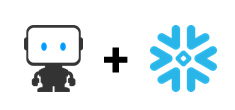

## Notebook overview

This notebook focuses on working with **Snowflake** as a data source and walks through how to use the Python API client to:

1. [Connect to DataRobot](#Setup)
2. [Import data from Snowflake into the AI catalog](#Import)
3. [Create a project and run Autopilot](#Project)
4. [Select and evaluate the top recommended model from a project)](#Eval)
5. [Deploy a model in a Docker container with a REST API endpoint](#Deploy)
6. [Orchestrate scheduled predictions with an MLOps job definition](#Schedule)

### Libraries used in this notebook

* The [**DataRobot Python client**](https://pypi.org/project/datarobot/).
* [**Snowflake Python Connector**](https://docs.snowflake.com/en/user-guide/python-connector.html) if pulling the demo dataset to follow along with this notebook.
* **Matplotlib** for model evaluation.
* **Pandas** for model evaluation.

#### Optional:  Import public demo data

For this walkthrough, you can use a publicly available dataset (`DR_Demo_E-commerce_churn_train.csv`) from DataRobot's S3 bucket to create a table in your Snowflake instance. This will let you run the cells in this notebook and follow along.

You will need to update the fields below with your Snowflake information. You will also need the following files found in the same repo as this notebook:

* utils.py
* datasets.yaml

Once you are done with this walkthrough, remember to delete the data from your Snowflake instance.

**If you have already established a Snowflake data connection in DataRobot, make sure the following information matches your credentials and data connection details.**

In [1]:
from utils import prepare_demo_tables_in_db

C:\Users\AustinChou\anaconda3\lib\site-packages\snowflake\connector\options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (10.0.1), please install a version that adheres to: 'pyarrow<8.1.0,>=8.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [ ]:
# Fill out the credentials for your Snowflake instance. You will need write access to a database
db_user = 'your_username' # Username to access Snowflake database
db_password = 'your_password' # Password 
account = 'eg:datarobotap_partner.ap-southeast-2' # Snowflake account identifier, can be found in the db_url
db = 'YOUR_DB_NAME' # Database to Write_To
warehouse = 'YOUR_WAREHOUSE' # Warehouse 
schema = 'YOUR_SCHEMA' # Schema

db_url = 'jdbc:snowflake://{account}.snowflakecomputing.com/?warehouse={warehouse}&db={db}'.format(
    account = account,
    db = db,
    warehouse = warehouse
)

In [3]:
# Use the util function to pull the data from DataRobot's public S3 and import into your Snowflake instance
reponse = prepare_demo_tables_in_db(
    db_user = db_user,                        
    db_password = db_password,                
    account = account,                        
    db = db,                                  
    warehouse = warehouse,                     
    schema = schema
)

******************************
table: DR_Demo_E-commerce_churn_train


,customerID,Gender,Address state,Age,Loyalty member,User period,Days since previous purchase,# purchase(1 year),Purchase amount(1 year),Most recent purchased product cat,...,# purchased fashion products,Amnt purchased fashion products,# purchased interior products,Amnt purchased interior products,# website visits,Duration of website visits (mins),# product page visits,# favorite items,customer score,Is_dormant
0,customer_3297125,F,MI,35,no,28,76,1,536.0,Down vest,...,1,104,3,432.0,1,1,95,0,1360.0,True
1,customer_3297554,M,AR,24,no,15,40,2,1372.0,Interior accessories,...,1,686,3,421.0,26,133,195,0,2772.5,False
2,customer_3298372,F,NM,24,no,34,28,4,940.0,Other tops,...,2,92,4,458.5,13,66,90,0,4817.5,True
3,customer_3299409,F,VT,25,yes,21,0,7,748.0,Camisole,...,1,52,2,371.0,390,1953,35,30,2964.0,False
4,customer_3297708,F,WA,24,no,20,137,1,641.5,Storage goods,...,2,113,5,528.5,13,68,15,0,3157.5,True


info for  DR_Demo_E-commerce_churn_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customerID                         3333 non-null   object 
 1   Gender                             3333 non-null   object 
 2   Address state                      3333 non-null   object 
 3   Age                                3333 non-null   int64  
 4   Loyalty member                     3333 non-null   object 
 5   User period                        3333 non-null   int64  
 6   Days since previous purchase       3333 non-null   int64  
 7   # purchase(1 year)                 3333 non-null   int64  
 8   Purchase amount(1 year)            3333 non-null   float64
 9   Most recent purchased product cat  3210 non-null   object 
 10  Most recent purchased product ID   3333 non-null   object 
 11  # purchased fas

## Setup <a id='Setup'></a>

### Import libraries

In [4]:
import datarobot as dr

# The following are libraries used in this notebook during model evaluation
import matplotlib.pyplot as plt
import pandas as pd

### Connect to DataRobot

**To connect to DataRobot,** you need to provide your **API Token** and the **endpoint**. For more information, please refer to the following documentation:

* [**Create/Manage API keys via Developer tools in the GUI**](https://docs.datarobot.com/en/docs/platform/account-mgmt/acct-settings/api-key-mgmt.html#api-key-management)
* [**Different options to connect to DataRobot from the API client**](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html)

In [5]:
# API Token
token = open('..\\..\\API token.txt').read() # Load the API token from a .txt file for ease of repeatable access
DATAROBOT_API_TOKEN = token # You can also find the API token under the Developer Tools in the UI

# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = 'https://app.datarobot.com/api/v2'

# To connect from Jupyter notebook:
client = dr.Client(
    token=DATAROBOT_API_TOKEN, 
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix='AIA-E2E-SNF-17' # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

## Import data from Snowflake to DataRobot AI Catalog  <a id='Import'></a>

You can upload data to Datarobot in a variety of ways:

* Data Sources (e.g., through a Snowflake data connection)
* Local Files
* Links

In this notebook, you will upload a dataset from a **Snowflake** data source. To do so:

1. Retrieve the Snowflake data connection and credentials.
2. Create a new data source (i.e., setting up the query to a Snowflake data table) if needed.
3. Import the dataset into the AI Catalog.

### Retrieve credentials

You will need to provide your Snowflake credentials to DataRobot to ingest the data from Snowflake to the AI Catalog.

You can easily [create and configure your credentials in the DataRobot UI](https://docs.datarobot.com/en/docs/data/connect-data/stored-creds.html). DataRobot will store all your credentials in the Credentials Management tab under your profile on the platform.

You can also create a new set of credentials by using the `dr.Credential.create_basic` function:

In [6]:
# If you need to create the credentials, run this cell
# If you already have Snowflake credentials in DataRobot, DO NOT RUN THIS CELL
# Instead, run the next cell (needs to be uncommented) to retrieve your existing credentials

# Use the db_user and db_password from the Setup section

cred = dr.Credential.create_basic(
        name='[AIA] Your_Snowflake_Credentials', # Rename
        user=db_user,
        password=db_password,
    )

credential_id = cred.credential_id

If you have already created credentials on DataRobot, you can retrieve them via the API. This notebook uses the credentials named "Snowflake Sandbox Demo Connection" - **replace it with the name you've given your Snowflake credentials in DataRobot's Credentials Management.**

In [ ]:
# # If you already have Snowflake credentials in DataRobot, you can retrieve and reuse the same credentials
# # Uncomment and run this cell instead of creating new credentials

# CREDS_NAME = 'Snowflake Sandbox Demo Connection' # Replace with your credentials name given during Snowflake credentials creation

# credential_id = [cr.credential_id for cr in dr.Credential.list() if cr.name == CREDS_NAME][0]

# # You can verify that you have the right credential by showing the ID and name
# dr.Credential.get(credential_id)

### Retrieve a Snowflake data connection

You will also need to create a data connection from DataRobot to Snowflake. This will allow DataRobot to pull data directly from your Snowflake database.

You can easily [create a new data connection in the DataRobot UI](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html). You can find all your established data connections in the **Data Connections** tab under your profile on the platform.


You can also create a new data connection by finding the Snowflake driver and using the `dr.DataStore.create` function via the API.

In [7]:
# Find a Snowflake driver ID by name. This can be skipped if you have the ID - code shown here for completeness
for d in dr.DataDriver.list():
    if d.canonical_name in 'Snowflake (3.13.9 - recommended)':
        print((d.id, d.canonical_name))

('626bae0a98b54f9ba70b4122', 'Snowflake (3.13.9 - recommended)')


In [8]:
# Create a datastore
# If you already have the Snowflake data connection to the right database in DataRobot, DO NOT RUN THIS CELL 
# Instead, run the next cell (needs to be uncommented) to retrieve your existing credentials

# Use the db_url from the "Setup" section

data_store = dr.DataStore.create(
        data_store_type='jdbc',
        canonical_name='[AIA] Your New Snowflake Data Connection', # Rename
        driver_id='626bae0a98b54f9ba70b4122', # Snowflake driver id
        jdbc_url= db_url
    )

# Test new data connection; access with your Snowflake credentials
data_store.test(username=db_user,
                password=db_password)

data_store_id = data_store.id

If you have already created the data connection on DataRobot, you can retrieve it via API. This notebook uses a data connection named "Snowflake - TEST_DB" - **please replace with the name you've given your appropriate Snowflake data connection in DataRobot's Data Connections tab.**

In [ ]:
# # If you already have a Snowflake data connection to your Snowflake database in DataRobot, you can
# # retrieve and reuse the same connection. Uncomment and run this cell instead of creating a new connection.

# # Once the connection is established via the UI, you can retrieve your data connection by name
# DATA_STORE_NAME = 'Snowflake - TEST_DB' # Replace with your Data Store name given during Snowflake data connection creation

# data_store_id = [ds.id for ds in dr.DataStore.list() if ds.canonical_name == DATA_STORE_NAME][0]

# # You can verify that you have the right DataStore by name
# dr.DataStore.get(data_store_id)

Next, create a data source specifying the query that you will use to pull data from the Snowflake data connection and into the DataRobot AI Catalog. For more information, please refer to the [**DataRobot documentation on data sources**](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html#add-data-sources).

If you already set up an existing data source, you can search for it by name.

In [9]:
# Pick the data source
# If you had already established a data source, just pick the existing data source
# Otherwise, create a new data source

DATA_SOURCE_NAME = '[AIA] Snowflake ECommerce Churn' # Rename
query_train = 'SELECT * FROM ' + schema + '."DR_Demo_E-commerce_churn_train";' # Edit this query to pull the appropriate table

data_sources = [ds for ds in dr.DataSource.list() if ds.canonical_name == DATA_SOURCE_NAME] 

if len(data_sources) > 0:
    data_source_train = data_sources[0].id
    print('Existing data source ID:', data_source_train)
else:
    query_train = query_train 
    ds_params = dr.DataSourceParameters(data_store_id=data_store_id, 
                                        query=query_train)
    data_source_train = dr.DataSource.create(data_source_type='jdbc', 
                                             canonical_name=DATA_SOURCE_NAME, 
                                             params=ds_params).id
    print('New data source created (ID):', data_source_train)

New data source created (ID): 63c01e2e2ac154636713f3f3


### Import dataset to AI Catalog

To **upload a dataset to AI Catalog**, use the `dr.create_from_` family of functions. In this case, we use `create_from_data_source`.

In [10]:
new_dataset = dr.Dataset.create_from_data_source(data_source_id=data_source_train,
                                                 do_snapshot=True,
                                                 credential_id=credential_id)

# Update the dataset name in the AI Catalog
new_dataset.modify(name="[AIA] Ecommerce Customer Churn Data")

Datasets in the AI Catalog are assigned a **dataset ID** which you can use to reference/get the dataset via the API.

In [11]:
# Quick link to the AI Catalog dataset you just created
# The base link assumes you are on the DataRobot Managed AI Cloud
print(
    "AI Catalog URL: " + "https://app.datarobot.com/ai-catalog/" + new_dataset.id
)
print("Dataset ID: " + new_dataset.id)

AI Catalog URL: https://app.datarobot.com/ai-catalog/63c01e32f9d3700a378cb250
Dataset ID: 63c01e32f9d3700a378cb250


## Create a project and run Autopilot <a id='Project'></a>

You can **create DataRobot projects** directly from:

* A dataset in AI Catalog (using the dataset's ID in DataRobot)
* A pandas dataframe (you do not need to write back to a data source or disk)
* Directly from data sources

Once a project is created, you can pass in DataRobot options and start modeling. At a minimum, you need to provide the prediction **Target**. With just two function calls (`create_from_` and `analyze_and_model`), you can go from data to optimizing 10 to 100 models with data science best practices.

You can actively watch the project in action in the DataRobot UI once Autopilot is triggered - the API and UI are parallel gateways to working on the same project which allows for **cross-functional collaboration.**

Note that each created project is associated with a unique **project ID**. You can use the project ID to retrieve the project of interest via the API.

### Create a project

Create a DataRobot project by uploading the dataset.

In [12]:
project = dr.Project.create_from_dataset(
    dataset_id=new_dataset.id,
    project_name="[AIA] Ecommerce Churn Project")

In [13]:
# Quick link to the DataRobot project you just created
# The base link assumes you are on the DataRobot Managed AI Cloud
print(
    "DataRobot Project URL: " + "https://app.datarobot.com/projects/" + project.id + "/eda"
)
print("Project ID: " + project.id)

DataRobot Project URL: https://app.datarobot.com/projects/63c01e86572cd3b4f8673e9f/eda
Project ID: 63c01e86572cd3b4f8673e9f


### Initiate Autopilot

To start the Autopilot process, call the `analyze_and_model` function. Provide the prediction target as part of the function call and use the default "Quick" Autopilot mode.

In [14]:
project.analyze_and_model(
    target="Is_dormant",
    worker_count=-1 # Setting worker count to -1 will use your maximum available workers
)

Project([AIA] Ecommerce Churn Project)

In [15]:
# If you want to wait for Autopilot to finish, run this code
# You can set verbosity to 1 if you want to print progress updates as Autopilot runs
project.wait_for_autopilot(verbosity=0)

While out of scope for this notebook, you can set advanced options to further configure Autopilot with the `set_advanced_options` function before triggering `analyze_and_model`. For visibility, you can view the advanced options used by the current project (which would be the default options):

In [16]:
# View advanced options used by Autopilot for the project
project = dr.Project.get(project.id) # Update the project object after Autopilot

print("Advanced Settings used:")
project.list_advanced_options()

Advanced Settings used:


{'weights': None,
 'response_cap': False,
 'blueprint_threshold': None,
 'seed': None,
 'smart_downsampled': False,
 'majority_downsampling_rate': None,
 'offset': None,
 'exposure': None,
 'accuracy_optimized_mb': None,
 'events_count': None,
 'monotonic_increasing_featurelist_id': None,
 'monotonic_decreasing_featurelist_id': None,
 'only_include_monotonic_blueprints': False,
 'allowed_pairwise_interaction_groups': None,
 'blend_best_models': False,
 'scoring_code_only': False,
 'shap_only_mode': False,
 'prepare_model_for_deployment': True,
 'consider_blenders_in_recommendation': False,
 'min_secondary_validation_model_count': None,
 'autopilot_data_sampling_method': None,
 'run_leakage_removed_feature_list': True,
 'autopilot_with_feature_discovery': False,
 'feature_discovery_supervised_feature_reduction': None,
 'exponentially_weighted_moving_alpha': None,
 'external_time_series_baseline_dataset_id': None,
 'use_supervised_feature_reduction': True,
 'primary_location_column': Non

## Select and evaluate the top recommended model <a id='Eval'></a>

After Autopilot completes, you can evaluate the results. Evaluation can include compiling the Leaderboard as a dataframe, measuring performances across different partitions with different metrics, visualizing the ROC curve, analyzing Feature Impact and Feature Effects to understand each models' behaviors, and more. This can be done for every single model created by DataRobot.

As a simple example in this notebook, **select the recommended model created by Autopilot and evaluate**:

* LogLoss performance
* AUC performance
* ROC curve
* Feature Impact of Top 10 features

Note: The recommended model is the best performing model that DataRobot identifies during Autopilot and then effectively retrains the blueprint on 100% of the data. For more information, refer to the [Model recommendation process documentation](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/model-rec-process.html#model-recommendation-process).

In [17]:
# Select the model recommended by DataRobot AutoML
top_model = project.recommended_model()

In [18]:
# Quick link to the recommended model built by Autopilot
print(
    "Top Model URL: " + top_model.get_uri()
)
print("Top Model Type: " + top_model.model_type)

Top Model URL: https://app.datarobot.com/projects/63c01e86572cd3b4f8673e9f/models/63c0207facae2e21f7805629
Top Model Type: Light Gradient Boosted Trees Classifier with Early Stopping


### Model performance by metric

In [19]:
print("Top Model LogLoss performance: " + str(top_model.metrics['LogLoss']['crossValidation']))
print("Top Model AUC performance: " + str(top_model.metrics['AUC']['crossValidation']))

Top Model LogLoss performance: 0.4218
Top Model AUC performance: 0.8545639999999999


### Create an ROC Curve

Beyond the Leaderboard, you can access any analysis DataRobot does out-of-the-box for every single model. The example below reproduces the ROC curve by calling the `get_roc_curve` function from the top model.

In [20]:
# Retrieve ROC Curve
roc_object = top_model.get_roc_curve(source="crossValidation")
roc = pd.DataFrame(roc_object.roc_points)

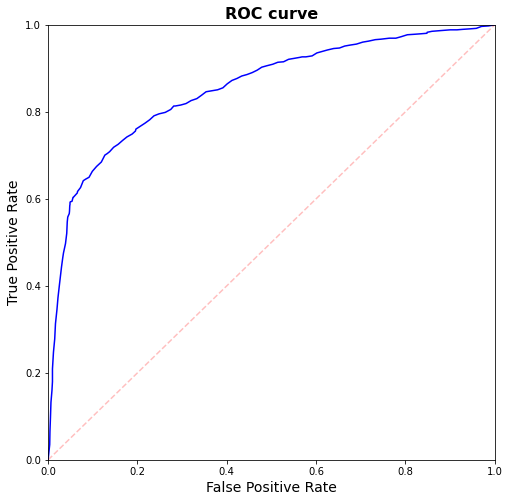

In [21]:
# Plot the ROC Curve
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor='w')

plt.plot(roc.false_positive_rate, roc.true_positive_rate, color='b')
plt.plot([0,1], [0,1], color='r', linestyle='dashed', alpha=0.25)
plt.title("ROC curve", size=16, fontweight="bold")
plt.xlabel("False Positive Rate", size=14)
plt.xlim([0,1])
plt.ylabel("True Positive Rate", size=14)
plt.ylim([0,1])
plt.show()

### Feature Impact

As an example of model explainability, we calculate the Feature Impact values of the model using the `get_or_request_feature_impact` function.

In [22]:
# Retrieve Feature Impact
feature_impacts = top_model.get_or_request_feature_impact() # Will trigger Feature Impact calculations if not done.
FI_df = pd.DataFrame(feature_impacts) # Convert to dataframe

# Sort features by Normalized Feature Impact
FI_df = FI_df.sort_values(by='impactNormalized', ascending=False)

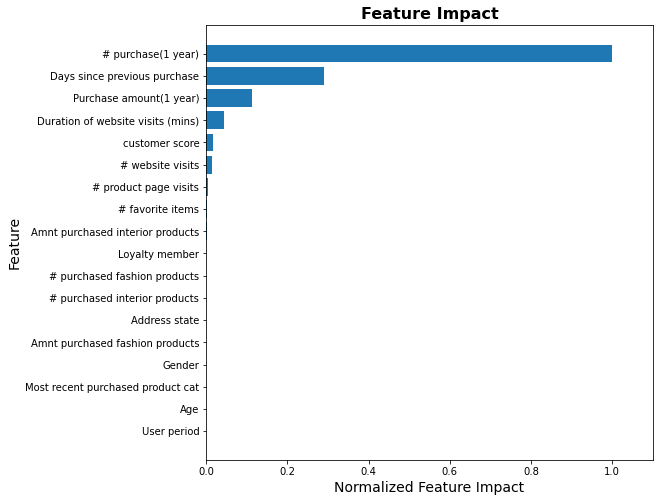

In [23]:
# Plot Feature Impact
FI_df["X axis"] = FI_df.index

# Plot
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor='w')

plt.barh(FI_df.featureName, FI_df.impactNormalized)
axes.invert_yaxis()
plt.title("Feature Impact", size=16, fontweight="bold")
plt.xlabel("Normalized Feature Impact", size=14)
plt.xlim([0,1.1])
plt.ylabel("Feature", size=14)
plt.show()

## Deploy a model with monitoring in MLOps <a id='Deploy'></a>

With a single function call or click on the UI, DataRobot can quickly deploy models into production while fully reproducing the entire modeling pipeline including the necessary data preprocessing steps utilized by the blueprints and any advanced feature engineering that are part of the project (such as in [Feature Discovery projects](https://www.datarobot.com/platform/feature-discovery/)). Once deployed, you can call DataRobot's REST or Python API to make batch and real-time predictions. You can also configure and schedule recurring batch prediction jobs that write back into a database.

Once a model is deployed, you can access MLOps monitoring capabilities such as:

- Service health
- Data drift
- Prediction accuracy
- Model retraining

To **deploy a model from the Leaderboard**, call the `create_from_learning_model` function and provide the **ID of the model** you want to deploy and the **ID of the prediction server** you want to deploy into.

For additional information, please see documentation for:

1. [**MLOps monitoring**](https://docs.datarobot.com/en/docs/mlops/mlops-overview.html) 
2. [**Available prediction methods**](https://docs.datarobot.com/en/docs/predictions/index.html)
3. [**Other deployment workflows with DataRobot**](https://docs.datarobot.com/en/docs/mlops/deployment/deploy-workflows/index.html)

In [24]:
# Prepare new deployment
deployment_model_id = top_model.id
prediction_server = dr.PredictionServer.list()[0]

# Create deployment
deployment = dr.Deployment.create_from_learning_model(
    deployment_model_id,
    label="[AIA] Customer Churn Deployment",
    description="[AIA] Customer Churn Prediction",
    default_prediction_server_id=prediction_server.id,
)

Every deployment in DataRobot is assigned a **deployment ID** which you can use to reference/retrieve the deployment via the API.

In [25]:
# Quick link to the deployment you just created
# The base link assumes you are on the DataRobot Managed AI Cloud
print(
    "DataRobot Deployment URL: " + "https://app.datarobot.com/deployments/" + deployment.id + "/overview"
)
print("Deployment ID: " + deployment.id)

DataRobot Deployment URL: https://app.datarobot.com/deployments/63c02177e0754bc1809ac3e1/overview
Deployment ID: 63c02177e0754bc1809ac3e1


### Configure model monitoring

In this example, you can set up the deployment to monitor data drift and accuracy using the following functions:

* Data drift: `update_drift_tracking_settings`
* Accuracy: `update_association_id_settings`

In [26]:
# Turn on Data Drift tracking for features and the target
deployment.update_drift_tracking_settings(target_drift_enabled=True, 
                                          feature_drift_enabled=True)

In [27]:
# Turn on Accuracy tracking by providing an association ID
deployment.update_association_id_settings(column_names=['customerID'], # Association ID to associate prediction results to actuals for accuracy monitoring
                                          required_in_prediction_requests=True)

## Orchestrate scheduled prediction jobs <a id='Schedule'></a>

You can **schedule a recurring batch prediction job** that looks up data from a data source (e.g.,  **Snowflake**), score predictions, and write back the results to a data table in a data source (e.g., **Snowflake**).

Similar to [**working in the UI**](https://docs.datarobot.com/en/docs/predictions/batch/batch-dep/batch-pred-jobs.html), you need to provide settings to set up a prediction job. In a [**code-first approach**](https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.0.2/reference/predictions/batch_predictions.html#batch-prediction-job-definitions-1), this is done by passing dictionaries containing settings for:

* Intake Settings (input data table or data source)
* Output Settings (output data table or data source)
* Schedule

You also need to provide the intake and output with IDs for:

* Data Store (i.e., data connection as set up in DataRobot)
* Credentials for the data store (as set up in DataRobot)

In [28]:
# Select the data store and credentials needed
# This notebook uses the same Snowflake data store and credentials as the ones used
# at the start of this notebook
writeback_data_store_id = data_store_id 
writeback_cred_id = credential_id 
    
# Set the Snowflake catalog (database) and schema for intake and output
# This notebook uses the same Snowflake database and schema as the ones
# at the start of this notebook
intake_catalog = db 
intake_schema = schema
output_catalog = db
output_schema = schema

In [29]:
# Set up settings dictionaries - edit this to your data and prediction pipeline

# Intake settings
# This example uses the training dataset as if it was also used for scoring
intake_settings = {
    'type': 'jdbc',
    'table': 'DR_Demo_E-commerce_churn_train', # Data table in data source
    'schema': intake_schema,
    'catalog': intake_catalog,
    'data_store_id': writeback_data_store_id,
    'credential_id': writeback_cred_id
}

# Output settings
output_settings = {
    'type': 'jdbc',
    'table': 'E-commerce_churn_prediction_demo_output', # Rename; Data table to write out to
    'schema': output_schema,
    'catalog': output_catalog,
    'statement_type': 'insert',
    'create_table_if_not_exists': True,
    'data_store_id': writeback_data_store_id,
    'credential_id': writeback_cred_id
}

# Schedule settings
schedule = {
        "minute": [59],
        "hour": [7],
        "month": ["*"],
        "dayOfWeek": ["*"],
        "dayOfMonth": [1]
}

In [30]:
# Set up the job dictionary
# Includes intake and output settings within the job dictionary
job = {
    "deployment_id" : deployment.id,
    "num_concurrent": 4,
    "intake_settings" : intake_settings,
    "output_settings" : output_settings,
    "passthroughColumnsSet": "all"
}

# Create the Batch Prediction job definition
job_definition = dr.BatchPredictionJobDefinition.create(
       enabled=True,
       batch_prediction_job=job,
       name="[AIA] ECommerce Churn - Monthly Prediction Job JDBC", # Make sure you use a unique name from other existing JobDefinitions in your organization
       schedule=schedule
)

The job definition should now be listed in the deployment's **Job Definitions** tab.

As a test, you can trigger the job manually to see DataRobot MLOps in action. **The next snippet will manually trigger the Job Definition to run.**

In [31]:
# Trigger the job manually
job_definition.run_once()

BatchPredictionJob(batchPredictions, '63c021e121006d023553c470', status=INITIALIZING)

When the job completes successfully, you will find the output written to the corresponding Snowflake table. The MLOps deployment will also update accordingly and you should see service health and data drift metrics update.

## Clean up

To remove everything added in the DataRobot platform as part of this notebook, run the following cell. If you want to delete any tables created in Snowflake as a result of running this notebook, you will need to manually do so in Snowflake.

In [32]:
# # CLEAN UP - Uncomment and run this cell to remove everything you added during this session

# job_definition.delete()
# deployment.delete()
# project.delete()
# new_dataset.delete(new_dataset.id)
# dr.DataSource.get(data_source_train).delete()
# data_store.delete()
# cred.delete()

## Additional Resources

* Check the [**DataRobot Community AI Accelerator page**](https://community.datarobot.com/t5/ai-accelerators/bd-p/ai_accelerators) for similar walkthroughs using DataRobot with other data sources (e.g. AWS, GCP, Azure, etc).
* Check the [**DataRobot API user guide for other code examples**](https://docs.datarobot.com/en/docs/api/guide/python/index.html) covering various topics such as model factories, feature impact rank ensembling, and more.